In [3]:
# Required packages
import pandas as pd
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
# Import functions
from data_processing import *
from model_handling import *

## Create the features

In [5]:
# Read file with labels and patches' information
xl_file = pd.ExcelFile('HP_WSI-CoordAllAnnotatedPatches.xlsx')
patient = pd.read_csv('PatientDiagnosis.csv')

dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}

df = dfs['Sheet1']
df = df.loc[df['Presence'] != 0] # Delete uncertain cases

### Data split

In [6]:
# Obtain IDs
trainval_ids = get_patient_ids('Cropped')
test_ids = get_patient_ids('HoldOut')

print(f'TrainVal Patients: {len(trainval_ids)}')
print(f'Test Patients: {len(test_ids)}')

TrainVal Patients: 155
Test Patients: 116


In [7]:
train_ids = []
index = 0  

# Iterate until we collect 20 entries with non-infected patients for the train split
while len(train_ids) < 20:
    densitat = patient.loc[patient['CODI'] == trainval_ids[index], 'DENSITAT'].values[0]
    
    if densitat == 'NEGATIVA':
        train_ids.append(trainval_ids[index])
    
    index += 1

val_ids = [item for item in trainval_ids if item not in train_ids]

print(f'Train Patients: {len(train_ids)}')
print(f'Validation Patients: {len(val_ids)}')

Train Patients: 20
Validation Patients: 135


Data is divided into four distinct splits, each serving a specific purpose:

- **train_set**: Used exclusively to train the autoencoder for image reconstruction.
- **annotated_set**: Designed for training in patch classification and visualization tasks.
- **validation_set**: Used for training patient classification models.
- **test_set**: Reserved for evaluating performance.

In [ ]:
# Retrieve the information from the corresponding folder
annotated_data = extract_data("Annotated", patient, split=val_ids, annotated=True, data=df)
train_set = extract_data("Cropped", patient, split=train_ids, train=True)
validation_set = extract_data("Cropped", patient, split=val_ids)
test_set = extract_data("HoldOut", patient, split=test_ids)

### Train autoencoder

In [30]:
# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder()

# Define transformations
transform = transforms.Compose([  
    transforms.Resize((256, 256)), # Ensure images are 256x256  
    transforms.ToTensor()  # Convert to tensor and scale to [0, 1] range    
])

# Create dataloader
trainloader = DataLoader(PILImageDataset(train_set, transform), batch_size=64, shuffle=True) 

In [31]:
train_ae(model, trainloader, device=device)

Epoch [1/10], Loss: 0.0020
Epoch [2/10], Loss: 0.0013
Epoch [3/10], Loss: 0.0013
Epoch [4/10], Loss: 0.0009
Epoch [5/10], Loss: 0.0007
Epoch [6/10], Loss: 0.0006
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0004


### Perform inferences and compute features

In [ ]:
# Prepare data to be processed by the autoencoder
# Load model and weights
model = ConvAutoencoder()
model.load_state_dict(torch.load("trained_model.pth", weights_only=True))

# Set model to evaluation mode
model.eval()

# Define the device that will be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dataloaders
annotatedloader = DataLoader(PILImageDataset(annotated_data, transform), batch_size=64, shuffle=False) 
validationloader = DataLoader(PILImageDataset(validation_set, transform), batch_size=64, shuffle=False) 
testloader = DataLoader(PILImageDataset(test_set, transform), batch_size=64, shuffle=False) 

In [58]:
# Create features for the patches
patch_features(annotatedloader, model, annotated_data, device=device)
patch_features(validationloader, model, validation_set, device=device)
patch_features(testloader, model, test_set, device=device)

In [ ]:
# Save datasets
with open('annotated_data.pkl', 'wb') as f:
    pickle.dump(annotated_data, f)
with open('validation_set.pkl', 'wb') as f:
    pickle.dump(validation_set, f)
with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

### Visualization

In [60]:
# Example
annotated_data['B22-25']

{'images': [{'img_path': '/kaggle/input/helicobacter/Annotated/Annotated/B22-25_0/02816.png',
   'label': -1,
   'features': [0, 0, 1.0]},
  {'img_path': '/kaggle/input/helicobacter/Annotated/Annotated/B22-25_0/02817.png',
   'label': -1,
   'features': [0, 0, 1.0]}],
 'patient_label': -1}

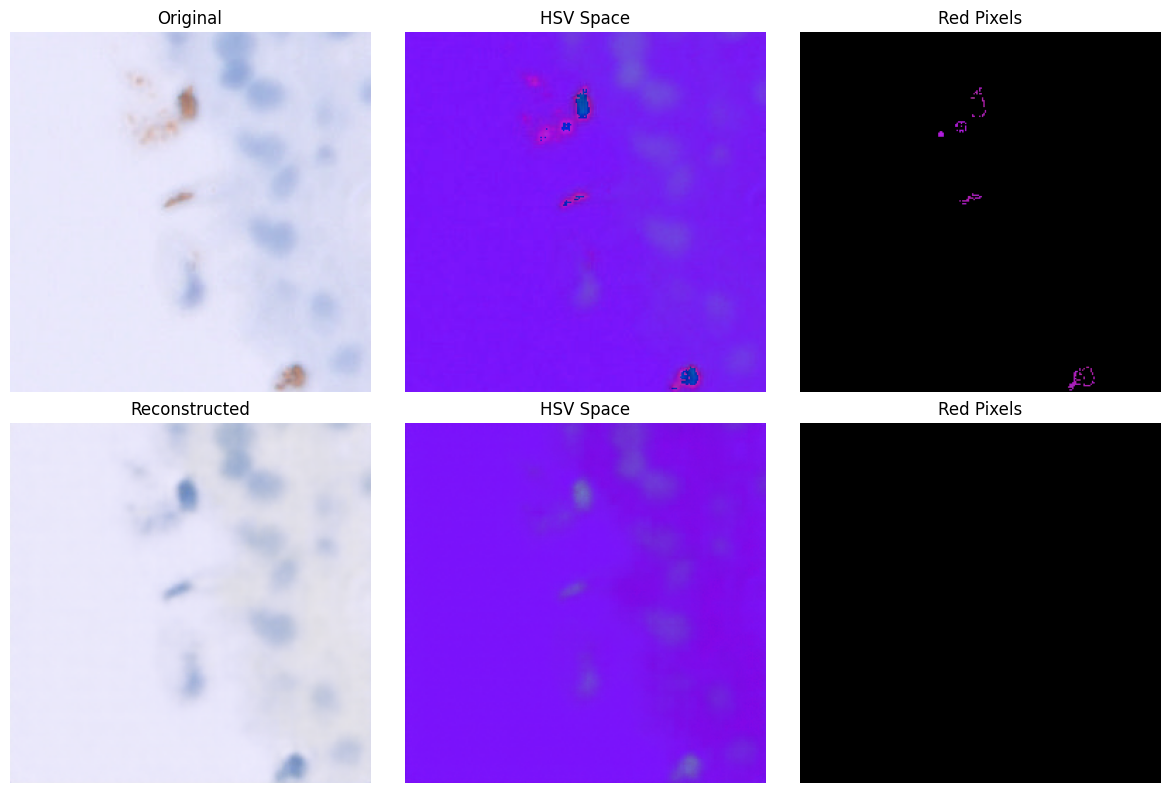

In [49]:
# Visualize results
visualize(annotatedloader, model, annotated_data, num_images=1, mode='complex', label=1, device=device)

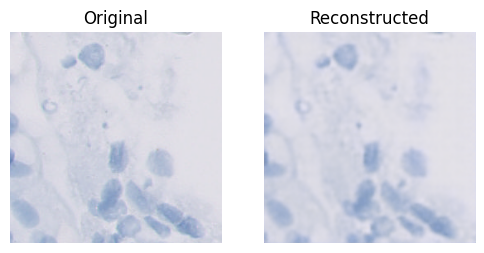

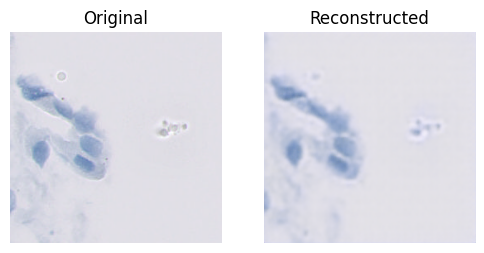

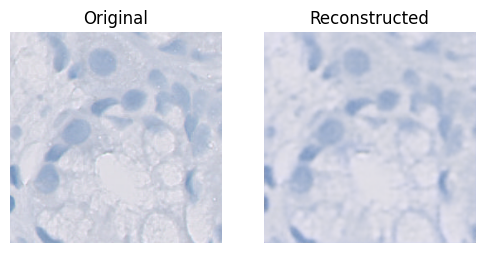

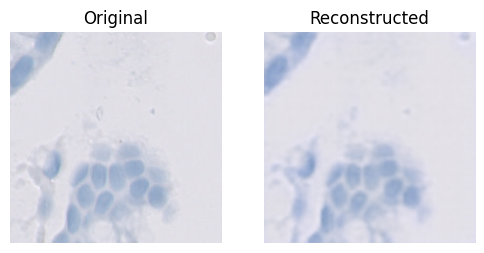

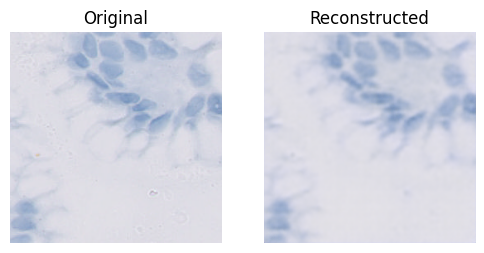

In [52]:
# Visualize results
visualize(annotatedloader, model, annotated_data, num_images=5, mode='simple', label=-1, device=device)

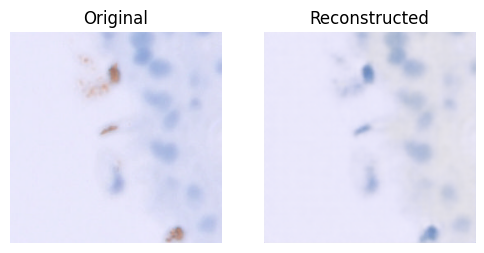

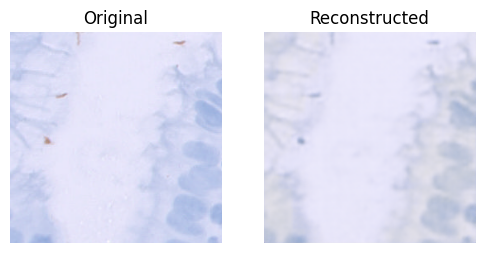

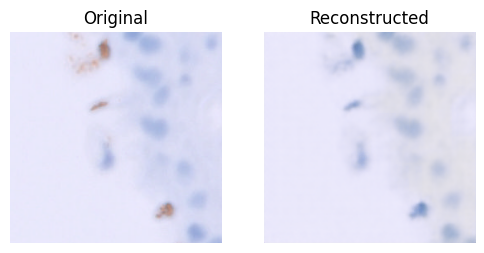

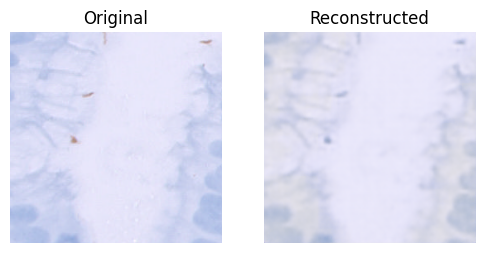

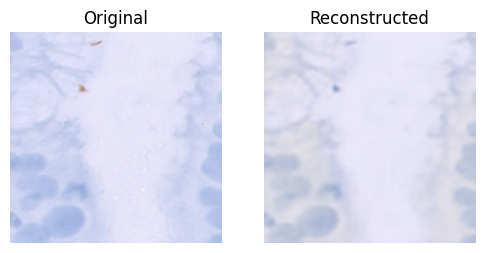

In [53]:
# Visualize results
visualize(annotatedloader, model, annotated_data, num_images=5, mode='simple', label=1, device=device)